# UC San Diego: Neural Data Science
## Classifying aversive dynamic stimuli from spiking and LFP activity in the human amygdala

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [ x ] YES - make available
* [  ] NO - keep private

# Names

- Eric Xiao
- Maxwell (Xiangheng) Chen

# Overview

In our project, our goals are two folded as we want to conduct feature extraction from both the Time and Frequency domain as well as pattern adapted wavelet domain. Then we will use K-means clustering to conduct feature selection and obtain feature vectors for all the recorded trails. These vectors will then be used to train the various classification models. We also used our cleaned data for deep learning with the Keras package to see if a multilayer dense core, softmax classifier, and 27 million generated parameters would be any better than traditional machine learning algorithms.

<a id='research_question'></a>
# Research Question

* How accurately can we classify neutral vs. aversive stimulus conditions from iEEG recording and spike time data?


<a id='background'></a>

## Background & Prior Work

With EEG recording becoming more and more accessible and prevalent, researchers are often flooded with data, however it is often very challenging to efficiently separate out the artifacts from the signals and extrapolate useful features. Our main research focuses on the same problem as we aim to find an appropriate model to decode the iEEG signals to distinguish the dynamic aversive stimulus presented to the patients.

Intracranial electroencephalography (iEEG) measures the electric field potentials in the brain by placing an array of grid, strip, or depth electrodes on the surface of the brain. These measurements have an excellent signal-to-noise ratio and iEEG signals have often been used to decode brain activity or drive brain-computer interfaces (BCIs). Although all intracranially implanted electrodes measure broad brain activity, the neurophysiological activity related to a many specific cognitive behaviors are only detected in subsets of the electrodes. The primary goal of recent iEEG classification studies have been relying on physiological brain activity to assist with better “channel selection” in motor-imagery tasks, emotion tasks, sleep stage detection, and cognitive tasks. The primary goal of these studies is to improve task-related classification performance, and techniques.

References (include links):
- 1) Fedele, T., Boran, E., Chirkov, V. et al. Dataset of spiking and LFP activity invasively recorded in the human amygdala during aversive dynamic stimuli. Sci Data 8, 9 (2021). https://doi.org/10.1038/s41597-020-00790-x
- 2) Brinkmann, B. H., Bower, M. R., Stengel, K. A., Worrell, G. A. & Stead, M. Large-scale Electrophysiology: Acquisition, Compression, Encryption, and Storage of Big Data. J. Neurosci. Methods 180, 185–192 (2009). https://mayoclinic.pure.elsevier.com/en/publications/large-scale-electrophysiology-acquisition-compression-encryption-
- 3) Amin, Hafeez Ullah. “Classification of EEG Signals Based on Pattern Recognition Approach.” Frontiers, 2017, www.frontiersin.org/articles/10.3389/fncom.2017.00103/full.

# Hypothesis


We hypothesize that the presence of a neutral vs. aversive visual stimulus produces a measurable physiological change in the human amygdala. We hope that this change will manifest itself in the iEEG recording or in the spike train recording. If such a difference exists, we should be able to train a binary classifier to accurately predict whether or not a subject is observing a neutral or aversive stimulus.

# Dataset

- Dataset Name: Dataset of neurons and intracranial EEG from human amygdala during aversive dynamic visual stimulation
- Link to the dataset: https://doi.gin.g-node.org/10.12751/g-node.270z59/
- Number of observations: 9 subjects, 17 trials of intracranial EEG recordings from each

This dataset contains the electrophysiological data of 9 epileptic patients presented with visual sequences of fearful faces (aversive condition) and neutral landscapes (neutral condition). The data itself consists of recordings of intracranial EEG and neuronal spike times and waveforms recorded from the left and right (varies) amygdalae during 17 trials of visual sequences for each patient.

# Data Wrangling

* The dataset consisted of multiple .h5 files, one for each subject.
* We opted to use Google Colab to collaborate on the data processing. The data files were downloaded locally, uploaded to Google Drive, and accessed through Google Colab.
* Loading data from raw .h5 files was time-consuming, so after data wrangling the DataFrames are exported as .csv files.
* For the data analysis later on in this notebook, we will load directly from the .csv files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os               # for directory access tools
import h5py             # for opening .h5 files
import re               # for string regex
from h5py import Group  # for opening .h5 files
import pandas as pd     # for data organization

In [ ]:
# To run data wrangling code without Google Colab, change data_dir to directory
# containing .h5 files of subjects
data_dir = r'/content/drive/Shareddrives/COGS 138 Encoding Decoding/10.12751_g-node.270z59/data_NIX/'

# Alternatively, change iEEG_dir to directory containing .csv files of subjects'
# iEEG recordings
iEEG_dir = r'/content/drive/Shareddrives/COGS 138 Encoding Decoding/iEEG data/'

subjects = {}  # dict of (subject id): (DataFrame of iEEG data from trials)

# Neutral trials are all odd, aversive trials are all even
neutral_trials = ['01', '03', '05', '07', '09', '11', '13', '15', '17']
aversive_trials = ['02', '04', '06', '08', '10', '12', '14', '16']

In [ ]:
# Iterate through all subject data
for filename in os.listdir(data_dir):
  if filename.endswith('.h5'):
    # Retrieve data from file
    file = h5py.File(data_dir + filename, 'r')
    data = file['data']
    filename_tokens = re.split(r'[.]', filename)
    subject_session = filename_tokens[0]
    subject = data.get(subject_session)
    data_arrays = subject.get('data_arrays')

    # Get subject ID from filename
    subject_tokens = re.split(r'[_]', subject_session)
    subject_id = subject_tokens[2]
    print('Reading data for Subject', subject_id)

    df = None

    # Iterate through subject's trial data
    for key in data_arrays.keys():
      if key.startswith('iEEG_Data'):
        # Is this trial neutral or aversive?
        # Encoding: neutral = 1, aversive = 2
        key_tokens = re.split(r'[_]', key)
        print('Reading data for Trial', key_tokens[3])
        if key_tokens[3] in neutral_trials:
          condition = 1
        elif key_tokens[3] in aversive_trials:
          condition = 2
        else:
          condition = 0  # 0 indicates invalid condition

        # Convert to Pandas DataFrame for ease of use
        iEEG_trial_data = pd.DataFrame(data_arrays.get(key)['data'])

        # For some reason, trials recording only one side list the data as
        # a column instead of a row (see Subject 03)
        if len(iEEG_trial_data) > 2:
          iEEG_trial_data = iEEG_trial_data.T

        # Mark left and right channels
        if len(iEEG_trial_data) == 2:
          iEEG_trial_data['channel'] = ['AL', 'AR']
        else:
          if subject_id in only_left_subs:
            iEEG_trial_data['channel'] = 'AL'
          elif subject_id in only_right_subs:
            iEEG_trial_data['channel'] = 'AR'
          else:
            print('Cannot find channel labels for subject', subject_id)
            break
          
        # Label condition and trial info
        iEEG_trial_data['condition'] = condition
        iEEG_trial_data['trial'] = key_tokens[3]

        # Move label data to beginning
        cols_to_move = ['trial', 'condition', 'channel']
        iEEG_trial_data = iEEG_trial_data[cols_to_move + [col for col in iEEG_trial_data.columns if col not in cols_to_move]]

        # Append to existing data
        if not isinstance(df, pd.DataFrame):
          df = iEEG_trial_data
        else:
          df = df.append(iEEG_trial_data, ignore_index=True)
      
      # temp break just to test data output
      # break
    
    subjects[subject_id] = df

# Result: subjects dict is populated with DataFrames for each subject

In [ ]:
# For future use, write DataFrames to csv files
for id, df in subjects.items():
  df.to_csv(iEEG_dir + 'subject_' + id + '_iEEG.csv', index=False)

In [ ]:
# Load iEEG data from .csv files
EEG_data = {}
subject_ids = ['01', '02', '03', '04', '05', '06', '07', '08', '09']
for id in subject_ids:
  EEG_data[id] = pd.read_csv(iEEG_dir + 'subject_'+id+'_iEEG.csv')

In [ ]:
# Sample of data format
# Three columns of trial number, condition number, channel type
# Followed by 52000 iEEG data points sampled at 2 kHz for 26 seconds
EEG_data['01'].head()

,trial,condition,channel,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,51960,51961,51962,51963,51964,51965,51966,51967,51968,51969,51970,51971,51972,51973,51974,51975,51976,51977,51978,51979,51980,51981,51982,51983,51984,51985,51986,51987,51988,51989,51990,51991,51992,51993,51994,51995,51996,51997,51998,51999
0,1,1,AL,-12.385750,-19.389157,-18.241749,-19.618881,-19.671290,-23.795124,-23.202507,-23.372883,-22.523346,-18.464864,-23.791950,-24.864350,-24.134639,-22.639589,-22.498908,-26.754575,-25.921118,-24.888754,-23.104116,-20.846573,-21.835331,-22.994696,-20.593274,-22.915839,-24.821229,-25.867166,-25.596377,-26.100059,-24.646605,-24.962156,-24.493187,-21.135753,-24.634437,-25.037501,-22.404091,-24.513452,-23.212489,...,-28.539042,-27.878542,-28.552798,-26.977433,-25.580362,-22.700460,-23.344881,-21.158547,-20.172843,-21.117286,-20.218597,-19.596987,-18.831561,-21.660169,-18.727352,-18.531673,-18.632067,-19.075671,-19.124550,-20.256898,-20.573896,-22.209035,-24.604936,-23.399132,-19.587498,-23.114763,-20.795242,-20.276084,-16.746138,-15.569659,-15.779295,-18.754141,-16.393828,-13.479611,-15.103905,-16.467829,-13.397270,-12.613410,-11.578060,-8.819195
1,1,1,AR,-2.085704,-4.017174,-5.157550,-2.848749,-4.104085,-5.994250,-2.745742,-3.987208,-5.094233,-2.997831,-2.854417,-6.701623,-0.748367,-0.026081,-1.335540,-0.271693,-0.958391,0.979864,-1.024923,-0.725548,-0.474137,0.673022,-0.591240,-0.517727,-3.190268,-2.011250,-2.104577,-3.847010,-2.942530,-6.405147,-2.970176,-4.081833,-2.696945,-1.266494,-4.744370,-4.015929,-2.210221,...,-1.682267,-3.940561,-2.760131,-1.316194,0.150838,2.118764,0.947511,1.257857,1.500948,7.453199,4.639063,6.151457,8.082107,7.232914,9.016695,9.606368,7.298846,8.953288,8.351383,6.821624,7.833322,7.777231,9.478458,12.486382,13.427564,10.405215,12.167870,13.314776,11.044862,9.886446,11.812592,10.244743,12.301424,12.535633,10.745004,8.781623,9.094525,10.424280,8.621871,8.980908
2,2,2,AL,-3.667529,-3.660116,-2.811257,-2.255469,-2.603543,-1.324368,-0.051883,-2.351034,-5.478216,-2.898021,-3.503656,-2.991282,-5.258270,-4.777496,-4.023533,-4.458108,-2.721744,-1.838695,-2.887317,-2.658760,-2.216242,-2.140067,-4.327276,-2.007310,-2.867540,-5.307051,-6.165921,-4.999501,-4.898879,-8.117181,-6.702013,-6.780822,-10.672364,-9.911997,-9.235230,-12.031915,-9.861989,...,13.940226,13.957551,14.503201,15.931212,16.577360,15.578444,16.430123,18.397688,17.356383,17.965066,17.636449,14.793767,16.334248,15.865921,15.792649,15.490480,14.941948,14.878213,12.913004,12.945671,13.971384,12.608478,10.341987,11.316003,12.022068,11.718216,13.536561,16.174880,14.307893,15.133960,14.484243,16.531511,17.346072,13.019677,12.683187,10.476657,11.741042,9.690379,10.878784,11.607121
3,2,2,AR,-0.776822,-3.473407,-5.381525,-5.059637,-0.981927,-5.777940,-6.779656,-6.746908,-4.962539,-5.177086,-6.745843,-7.343323,-7.561523,-5.567397,-7.485423,-5.537392,-2.722599,-5.704832,-7.998875,-5.637335,-6.583437,-7.701917,-5.788655,-7.179536,-6.361675,-6.655853,-6.325137,-5.160832,-5.765025,-5.839203,-8.209286,-7.096087,-7.246170,-7.030542,-8.199401,-7.983530,-6.812532,...,-34.820609,-36.378028,-33.207821,-34.434315,-35.433261,-36.115516,-35.564389,-33.807596,-37.139299,-38.730118,-33.614724,-34.590652,-38.275715,-38.168062,-36.541112,-36.751963,-40.186653,-39.902591,-40.017916,-37.460473,-37.431426,-35.058042,-36.360945,-38.618059,-38.329593,-36.195652,-35.238843,-35.148960,-37.364847,-35.091789,-37.612764,-34.539424,-35.638099,-36.769999,-37.549154,-36.346758,-35.639523,-39.491278,-36.662284,-39.565935
4,3,1,AL,-1.155909,1.168292,5.264044,1.203829,2.911737,2.964448,0.423029,1.927717,3.016723,1.820611,1.206398,0.294125,0.525703,1.249460,-3.065817,-1.532035,-1.126021,-3.979287,-3.223311,-3.014288,-6.402874,-3.669356,-3.679895,-1.798011,-2.432847,-3.961589,-0.917783,-0.003674,-3.561797,-2.571915,0.025012,-1.592827,-2.843980,-2.719348,0.339164,0.001767,-1.655793,...,3.490078,3.767480,3.087317,4.417674,4.49

# Data Cleaning

* We planned to filter iEEG data, so we plotted power spectral density graphs to determine what frequencies we want to extract from the data.
* However, we found that there was little difference in PSD between neutral and aversive conditions for both the left and right amygdalae across all subjects.
* For all graphs in this notebook, blue indicates neutral stimulus and red indicates aversive stimulus.
* We did not continue to filter the iEEG data as we could not determine what range of frequencies we should extract from the signal to best distinguish neutral and aversive conditions.
* Data cleaning was not necessary for the spike times dataset.

In [ ]:
import matplotlib.pyplot as plt
from scipy.signal import welch
import numpy as np

In [ ]:
def split_data(data, subject_id):
  '''
  Splits data into left neutral, left aversive, right neutral, right aversive
  subsets. Excludes trial, condition, channel columns from output.
  '''
  data_id = data[subject_id]
  ln = data_id[(data_id['condition'] == 1) &
                (data_id['channel'] == 'AL')].drop(['trial', 'condition', 'channel'], axis=1)
  rn = data_id[(data_id['condition'] == 1) &
                (data_id['channel'] == 'AR')].drop(['trial', 'condition', 'channel'], axis=1)
  la = data_id[(data_id['condition'] == 2) &
                (data_id['channel'] == 'AL')].drop(['trial', 'condition', 'channel'], axis=1)
  ra = data_id[(data_id['condition'] == 2) &
                (data_id['channel'] == 'AR')].drop(['trial', 'condition', 'channel'], axis=1)
  return ln, la, rn, ra

def calc_welch_mean_range(data, fs=2000):
  '''
  Estimates PSD using Welch's method. Calculates average, minimum, and maximum
  values for each frequency point in the output, as well as the frequency
  points.
  '''
  Pxx_den_mat = None
  i = 0
  freqs = None
  for idx, row in data.iterrows():
    f, Pxx_den = welch(row, fs)
    if Pxx_den_mat is None:
      Pxx_den_mat = np.zeros((len(data), len(Pxx_den)))
    Pxx_den_mat[i] = Pxx_den
    i += 1
    freqs = f
  Pxx_den_max = np.amax(Pxx_den_mat, axis=0)
  Pxx_den_min = np.amin(Pxx_den_mat, axis=0)
  Pxx_den_mean = np.mean(Pxx_den_mat, axis=0)
  return Pxx_den_mean, Pxx_den_min, Pxx_den_max, freqs

def plot_welch_diff_left(data, subject_id, fs=2000, ax=None):
  '''
  Plots PSD using Welch's method for left neutral and left aversive conditions
  on the same graph for the given subject.
  '''
  ln, la, _, _ = split_data(data, subject_id)

  if ax is None:
    fig, ax = plt.subplots(1, 1)

  if len(ln) > 0:
    ln_mean, ln_min, ln_max, f = calc_welch_mean_range(ln, fs)
    la_mean, la_min, la_max, f = calc_welch_mean_range(la, fs)

    ax.semilogy(f, ln_mean, color='b')
    ax.semilogy(f, la_mean, color='r')

    ax.fill_between(f, ln_min, ln_max, facecolor='b', alpha=0.25)
    ax.fill_between(f, la_min, la_max, facecolor='r', alpha=0.25)

def plot_welch_diff_right(data, subject_id, fs=2000, ax=None):
  '''
  Plots PSD using Welch's method for right neutral and right aversive conditions
  on the same graph for the given subject.
  '''
  _, _, rn, ra = split_data(data, subject_id)

  if ax is None:
    fig, ax = plt.subplots(1, 1)

  if len(rn) > 0:
    rn_mean, rn_min, rn_max, f = calc_welch_mean_range(rn, fs)
    ra_mean, ra_min, ra_max, f = calc_welch_mean_range(ra, fs)

    ax.semilogy(f, rn_mean, color='b')
    ax.semilogy(f, ra_mean, color='r')

    ax.fill_between(f, rn_min, rn_max, facecolor='b', alpha=0.25)
    ax.fill_between(f, ra_min, ra_max, facecolor='r', alpha=0.25)

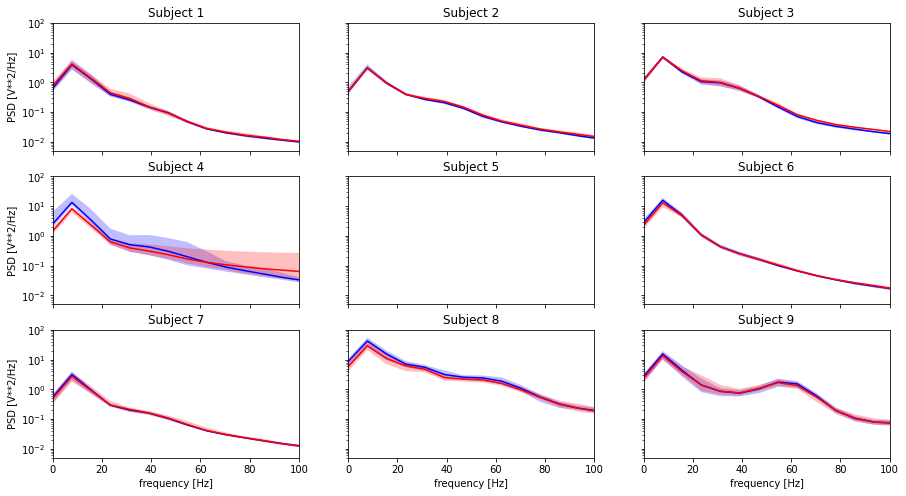

In [ ]:
# 3x3 grid of plots
fig, axs = plt.subplots(3, 3, figsize=(15,8), sharex=True, sharey=True)
((ax1, ax2, ax3),
 (ax4, ax5, ax6),
 (ax7, ax8, ax9)) = axs

# Title each plot
for i, ax in enumerate(axs.flat):
    ax.set_title(f'Subject {i+1}')

# Plot left neutral vs. left aversive PSD for all subjects
plot_welch_diff_left(EEG_data, '01', ax=ax1)
plot_welch_diff_left(EEG_data, '02', ax=ax2)
plot_welch_diff_left(EEG_data, '03', ax=ax3)
plot_welch_diff_left(EEG_data, '04', ax=ax4)
plot_welch_diff_left(EEG_data, '05', ax=ax5)
plot_welch_diff_left(EEG_data, '06', ax=ax6)
plot_welch_diff_left(EEG_data, '07', ax=ax7)
plot_welch_diff_left(EEG_data, '08', ax=ax8)
plot_welch_diff_left(EEG_data, '09', ax=ax9)

# Plot scale and labels
plt.setp(axs, xlim=[0, 1e2], ylim=[0.5e-2, 1e2])
plt.setp(axs[-1, :], xlabel='frequency [Hz]')
plt.setp(axs[:, 0], ylabel='PSD [V**2/Hz]')
plt.show()

We can see in the graphs above that for most subjects, there is no noticable difference in PSD for any frequency range in the left amygdala. A notable exception is Subject 4, whose graph indicates that for a frequency range of 0.5 - 20 Hz we may be able to distinguish neutral and aversive conditions, with the neutral condition having a higher PSD overall. Unfortunately, this pattern is not seen consistently in other subjects.

The graph for Subject 5 is missing because the dataset only contains recordings from the right amygdala for Subject 5.

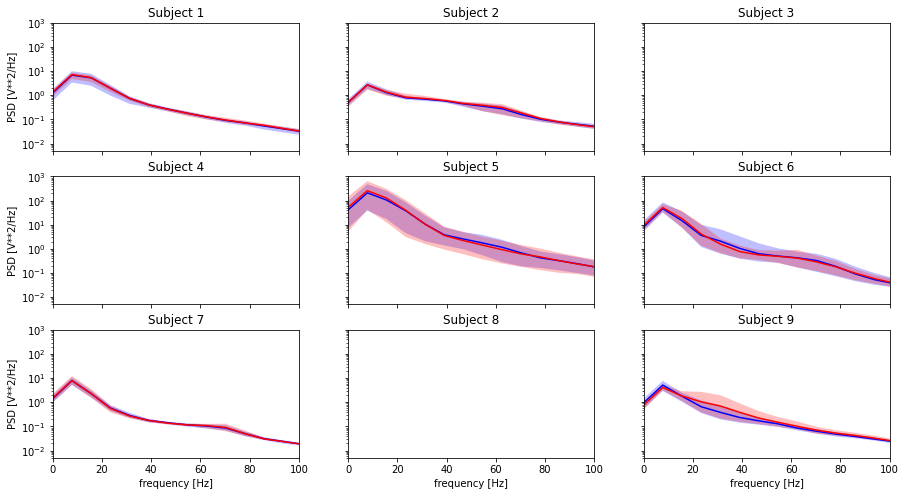

In [ ]:
# 3x3 grid of plots
fig, axs = plt.subplots(3, 3, figsize=(15,8), sharex=True, sharey=True)
((ax1, ax2, ax3),
 (ax4, ax5, ax6),
 (ax7, ax8, ax9)) = axs

# Title each plot
for i, ax in enumerate(axs.flat):
    ax.set_title(f'Subject {i+1}')

# Plot right neutral vs. right aversive PSD for all subjects
plot_welch_diff_right(EEG_data, '01', ax=ax1)
plot_welch_diff_right(EEG_data, '02', ax=ax2)
plot_welch_diff_right(EEG_data, '03', ax=ax3)
plot_welch_diff_right(EEG_data, '04', ax=ax4)
plot_welch_diff_right(EEG_data, '05', ax=ax5)
plot_welch_diff_right(EEG_data, '06', ax=ax6)
plot_welch_diff_right(EEG_data, '07', ax=ax7)
plot_welch_diff_right(EEG_data, '08', ax=ax8)
plot_welch_diff_right(EEG_data, '09', ax=ax9)

# Plot scale and labels
plt.setp(axs, xlim=[0, 1e2], ylim=[0.5e-2, 1e3])
plt.setp(axs[-1, :], xlabel='frequency [Hz]')
plt.setp(axs[:, 0], ylabel='PSD [V**2/Hz]')
plt.show()

Similarly to the set of graphs for the left amygdala, we can see in the graphs above that for most subjects, there is no noticable difference in PSD for any frequency range in the right amygdala. Notable exceptions are Subjects 6 and 9, whose graphs indicate that for frequency ranges of 30 - 50 Hz and 20 - 40 Hz, respectively, we may be able to distinguish neutral and aversive conditions, with the neutral condition having a higher PSD overall for Subject 6 and the aversive condition having a higher PSD overall for Subject 9. Unfortunately, these patterns are not seen consistently in other subjects.

The graphs for Subjects 3, 4, and 8 are missing because the dataset only contains recordings from the left amygdalae for Subjects 3, 4, and 8.

# Data Visualization

* In addition to iEEG data, we calculated and plotted instantaneous spike rates for all subjects to see if there was a noticable and consistent distinction.
* For all graphs in this notebook, blue indicates neutral stimulus and red indicates aversive stimulus.

In [ ]:
!pip install elephant

In [26]:
from elephant.statistics import instantaneous_rate
import quantities as pq
from neo import SpikeTrain

In [24]:
# Load spike times data from .csv files
spike_dir = r'/content/drive/Shareddrives/COGS 138 Encoding Decoding/Spike Times/'
spike_data = {}
subject_ids = ['01', '02', '03', '04', '07']

for id in subject_ids:
  spike_data[id] = pd.read_csv(spike_dir + 'subject_'+id+'_spiketimes.csv')

In [30]:
def calc_inst_rates(data):
  '''
  Calculates the instantaneous rates for the given spike train data for all
  trials individually.
  '''
  unit_ids = data.unit_id.unique()
  inst_rates = {}
  for i in unit_ids:
    num = data.loc[data['unit_id'] == i].iloc[0]['unit_num']
    key = str(i) + '_' + str(int(num))
    inst_rates[key] = []
    unit = data.loc[data['unit_id'] == i].drop(['unit_id', 'unit_num'], axis=1)
    for idx, row in unit.iterrows():
      row = np.array(row.dropna())
      rate = instantaneous_rate(SpikeTrain(row * pq.s, t_stop=24 * pq.s, t_start=-2 * pq.s), 10 * pq.ms)
      inst_rates[key].append(rate)
  return inst_rates

def average_inst_rates(inst_rates):
  '''
  Takes the average of all instantaneous rates across all trials.
  '''
  all_avg_rates = {}
  for key in inst_rates.keys():
    num_trials = len(inst_rates[key])
    sum_rates = np.zeros(len(inst_rates[key][0]))
    for rates in inst_rates[key]:
      sum_rates += np.array([float(x) for x in rates])
    avg_rates = sum_rates / num_trials
    all_avg_rates[key] = avg_rates
  return all_avg_rates

def plot_unit_spike_train(data_n, data_a, unit_id, ax, title=None):
  '''
  Plots neutral vs. aversive spike trains for the given unit.
  '''
  num = data_n.loc[data_n['unit_id'] == unit_id].iloc[0]['unit_num']
  unit_n = data_n.loc[data_n['unit_id'] == unit_id].drop(['unit_id', 'unit_num'], axis=1)
  unit_n = np.array(unit_n)

  unit_a = data_a.loc[data_a['unit_id'] == unit_id].drop(['unit_id', 'unit_num'], axis=1)
  unit_a = np.array(unit_a)

  unit = np.append(unit_n, unit_a, axis=0)
  unit = unit[:, ~np.isnan(unit).any(axis=0)]
  colors = ['b'] * len(unit_n) + ['r'] * len(unit_a)
  ax.eventplot(unit, colors=colors)
  if title is not None:
    ax.title(title + ', unit = ' + str(unit_id) + '_' + str(int(num)))

def plot_avg_inst_rates(spike_data, subject_id):
  '''
  Plots average instananeous spike rates across all trials for the given
  subject. Additionally plots spike train raster plot. Only plots left amygdala
  spike data.
  '''
  ln, la, rn, ra = split_data(spike_data, subject_id)
  # Calculate instantaneous rates for
  # each unit in left neutral and aversive sets
  ln_inst_rates = calc_inst_rates(ln)
  la_inst_rates = calc_inst_rates(la)

  ln_avg_rates = average_inst_rates(ln_inst_rates)
  la_avg_rates = average_inst_rates(la_inst_rates)

  for key in ln_avg_rates.keys():
    fig, ax = plt.subplots(2, 1)
    rate_plt, raster_plt = ax
    rate_plt.plot(ln_avg_rates[key], 'b')
    rate_plt.plot(la_avg_rates[key], 'r')
    rate_plt.set_ylabel('Firing rate in Hz')
    rate_plt.axes.xaxis.set_visible(False)
    key_tokens = re.split('[_]', key)
    raster_plt.set_xlabel('Time in seconds')
    raster_plt.axes.yaxis.set_visible(False)
    plot_unit_spike_train(ln, la, int(key_tokens[0]), raster_plt)
    plt.show()

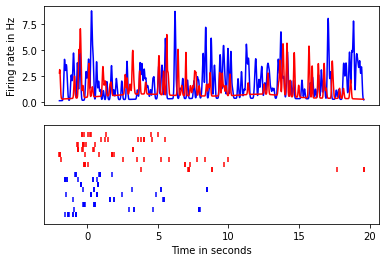

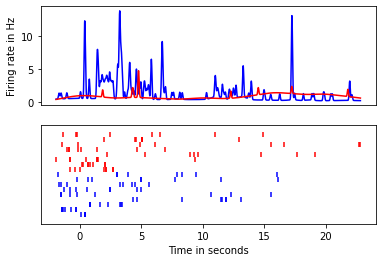

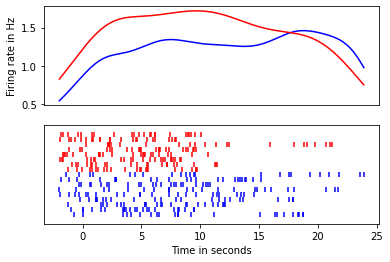

In [31]:
plot_avg_inst_rates(spike_data, '01')

Above are the graphs of average instantaneous firing rates for each of the three units for Subject 1. Units are vaguely defined in the original dataset, and we believe that they refer to specific neurons or neuron groups. While the paper associated with the original dataset found that, on average, the aversive condition is associated with a higher firing rate, we do not see a similar pattern consistently in our average instantaneous firing rate comparisions. Below we will plot the same graphs for the rest of the subjects. Some subjects in the dataset did not have any spike time recordings.

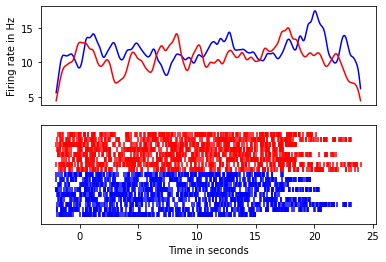

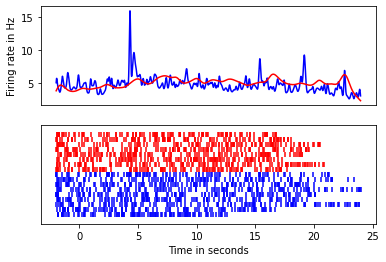

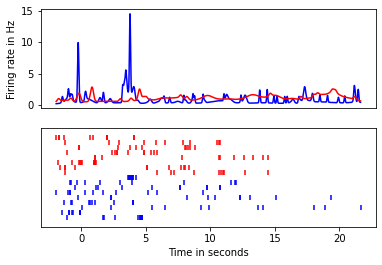

In [32]:
plot_avg_inst_rates(spike_data, '02')

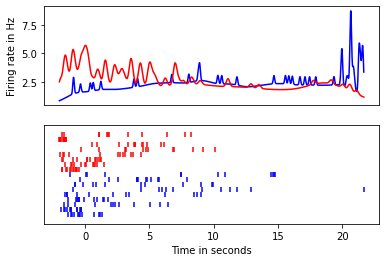

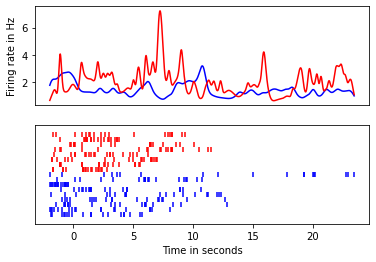

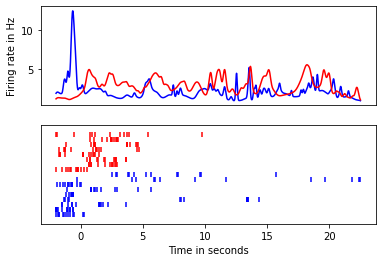

In [33]:
plot_avg_inst_rates(spike_data, '03')

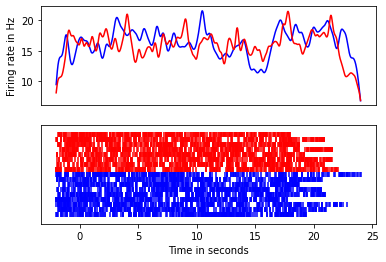

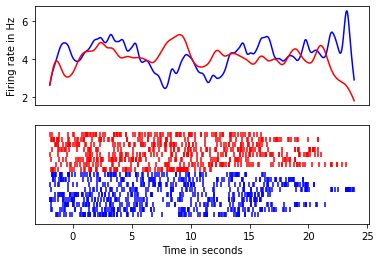

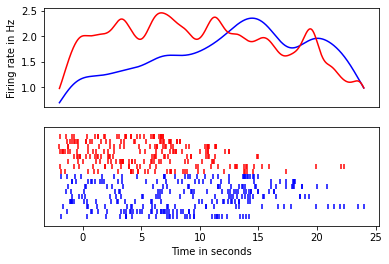

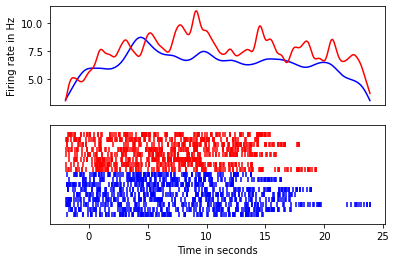

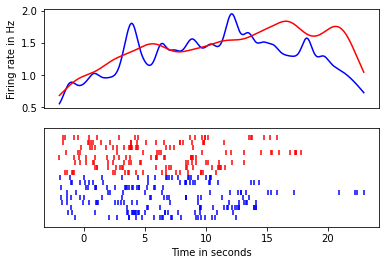

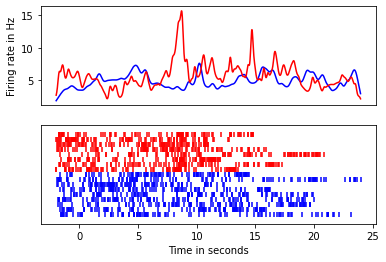

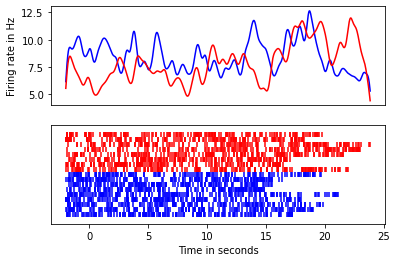

In [34]:
plot_avg_inst_rates(spike_data, '04')

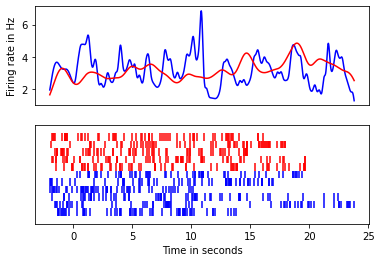

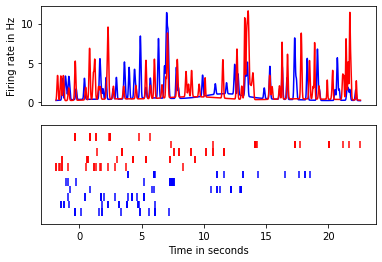

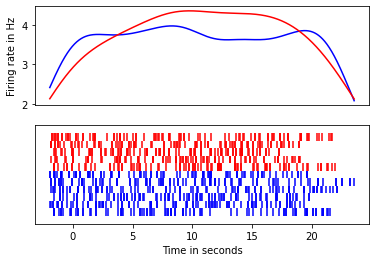

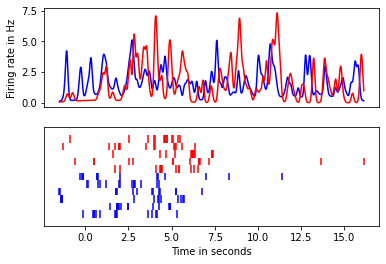

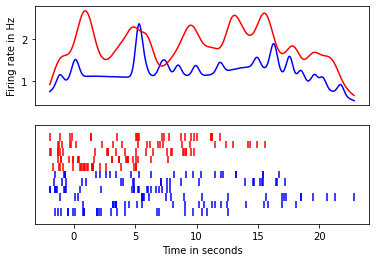

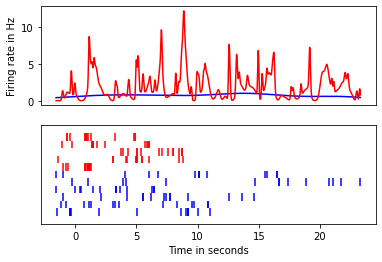

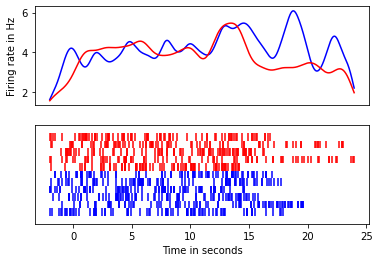

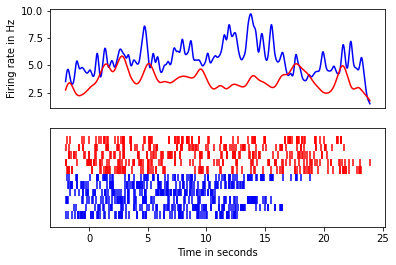

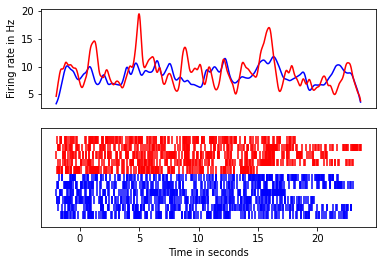

In [35]:
plot_avg_inst_rates(spike_data, '07')

We found that each unit has an additional associated number (which we call the "unit number", to distinguish it from the unit ID), which remains consistent for all recordings associated with that unit for a given subject. We do not know precisely what this number refers to, nor could we find any detail about the number in the original paper. We speculate that this number may be used to associate identical biological units across subjects, since the unit IDs are numbered sequentially starting from 1 for each subject. However, we do not see any concrete patterns in firing rates across units with the same unit number, so there is no evidence to support our speculation.

As we were unable to find a meaningful correlation between condition and average instantaneous firing rates, we did not proceed with using spike times data in our analysis.

# Data Analysis & Results

Below, we trained a softmax neural network with 3 layers of dense core and around 27 million parameters. The best accuracy score we were able to obtain is about 67.65%.

In [ ]:
data = pd.read_csv("combined_EEG.csv")

In [ ]:
y = data['condition'].copy()
X = data.drop('condition', axis=1).copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=123)

In [ ]:
inputs = tf.keras.Input(shape=(X_train.shape[1],))

expand_dims = tf.expand_dims(inputs, axis=2)

gru = tf.keras.layers.GRU(100, return_sequences=True)(expand_dims)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(3, activation='softmax')(flatten)


model = tf.keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

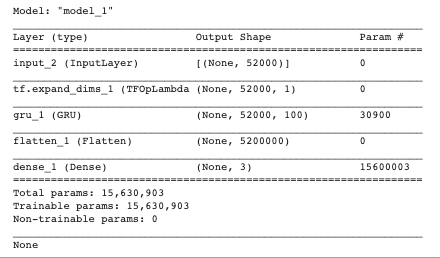

In [ ]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

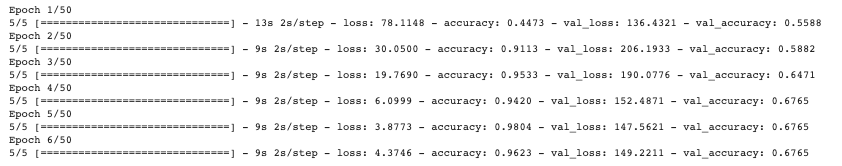

# Conclusion & Discussion

Through our analysis, we conclude that the accuracy of classification is poor. We were unable to establish a strong correlation between the features extracted from iEEG and spike times data with neutral and aversive conditions. The neural network trained on raw iEEG data reaches a validation accuracy of 67.65% at best. We consider this performance insufficient for a robust binary classification model. Despite the limitations of our study, we have nonetheless developed a framework for analyzing iEEG and spike train data collected from the human amygdala. We may find the opportunity to apply these methods of analysis on other datasets.

Although we find that it is difficult to classify iEEG and spike times data by their original stimulus, we do not believe that it is entirely impossible. The original paper was published with a plot of firing rates for neutral and aversive conditions which showed a distinct difference. The figure shows that under the aversive condition, firing rate is higher and "bursts" at certain time points. Although we are unable to replicate this result ourselves, we speculate that this may be the physiological change we are looking for.

It is also entirely possible that when the stimulus is presented, the signal produced by the amygdala is decomposed to such a degree that even binary classification is difficult. The primary assumption of this study is that the human amygdala will produce a similar physiological response to an aversive stimulus across all subjects. It may be the case that human emotional responses vary too much on an individual basis to develop a generalized model that can decode information from amygdalae.

There were many directions to explore with this dataset, however we were limited in time and expertise. For future work, we would like to explore the following areas:
* Exploring the MATLAB code provided in the original paper in attempt to replicate their spike rate result
* Using discrete wavelet transforms to extract features
* Extracting other features of the spike trains
* Analyzing EEG/iEEG or spike train datasets recorded from other parts of the brain